In [1]:
import torch
from DrawinGAN import Generator, Discriminator
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["figure.figsize"] = (8, 8)

%matplotlib inline

In [2]:
generator = Generator.DrawingGenerator(Generator.ConvBlock, output_channels=1).cuda(1)
discriminator = Discriminator.DrawingDiscriminator(input_channels=1).cuda(1)

In [30]:
model_root = r"D:\MLModels\SimpleStyleGAN\Good"

models_dict = {
    "discriminator": torch.load(model_root + "\\1561070753-discriminator.pth"),
    "generator": torch.load(model_root + "\\1561070753-generator.pth")
}

generator.load_state_dict(models_dict["generator"])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

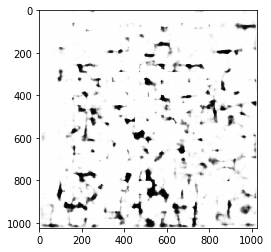

In [103]:
to_image = transforms.ToPILImage()

z = torch.randn(1, 512, 1, 1).cuda(1)

shift = torch.rand_like(generator.constant) + generator.constant

generator.constant.data = shift
fake = generator.forward(z, None)

grid = vutils.make_grid(fake.clone().cpu(), nrow=1, normalize=True)

im = to_image(grid)

plt.imshow(im)


In [24]:
z

tensor([[[[ 1.8395e+00]],

         [[ 5.0445e-01]],

         [[-7.9476e-01]],

         [[ 3.5819e-01]],

         [[-1.4927e+00]],

         [[ 1.2389e+00]],

         [[-4.9233e-01]],

         [[ 3.2920e-01]],

         [[ 1.6958e-01]],

         [[ 1.1060e+00]],

         [[-7.7375e-01]],

         [[-4.4337e-01]],

         [[ 8.8589e-02]],

         [[ 5.0424e-02]],

         [[-2.2228e+00]],

         [[-2.0114e+00]],

         [[-1.3429e+00]],

         [[ 6.6560e-01]],

         [[ 1.9734e-01]],

         [[-6.3591e-01]],

         [[-8.8253e-01]],

         [[ 2.0400e-01]],

         [[ 1.5756e+00]],

         [[ 2.6269e-03]],

         [[-1.7511e-01]],

         [[-1.9449e-01]],

         [[ 7.7323e-02]],

         [[ 1.4805e-01]],

         [[-1.7064e+00]],

         [[ 6.7454e-01]],

         [[-5.4023e-01]],

         [[ 9.4943e-01]],

         [[ 3.8116e-01]],

         [[ 4.3074e-01]],

         [[ 4.1151e-01]],

         [[-9.1104e-02]],

         [[ 4.9397e-01]],

 